In [ ]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load Images into TF data pipeline

In [ ]:
data_dir = "/content/drive/MyDrive/Deep Learning with Tensorflow/Face Detection/data"
images = tf.data.Dataset.list_files(f"{data_dir}/train/images/*.jpg", shuffle=False)

In [ ]:
images.as_numpy_iterator().next()

b'/content/drive/MyDrive/Deep Learning with Tensorflow/Face Detection/data/train/images/00036367-a602-11ee-a720-30d0423c1df5.jpg'

In [ ]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

array([[[150, 164, 175],
        [151, 165, 176],
        [149, 165, 180],
        ...,
        [ 81, 108, 117],
        [ 79, 109, 119],
        [ 78, 111, 120]],

       [[150, 164, 175],
        [149, 166, 176],
        [149, 165, 180],
        ...,
        [ 86, 110, 120],
        [ 82, 110, 121],
        [ 79, 109, 119]],

       [[148, 165, 175],
        [148, 165, 175],
        [149, 165, 180],
        ...,
        [ 88, 110, 121],
        [ 87, 114, 123],
        [ 85, 114, 122]],

       ...,

       [[ 41,  65,  77],
        [ 38,  65,  76],
        [ 38,  65,  76],
        ...,
        [ 74, 110, 110],
        [ 85, 121, 121],
        [ 75, 114, 113]],

       [[ 39,  65,  78],
        [ 36,  64,  75],
        [ 35,  63,  74],
        ...,
        [ 58,  98,  97],
        [ 72, 114, 112],
        [ 79, 124, 121]],

       [[ 36,  64,  76],
        [ 34,  62,  74],
        [ 32,  62,  72],
        ...,
        [ 59, 104, 101],
        [ 56, 101,  98],
        [ 59, 105, 102]]

# View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

<function matplotlib.pyplot.show(close=None, block=None)>

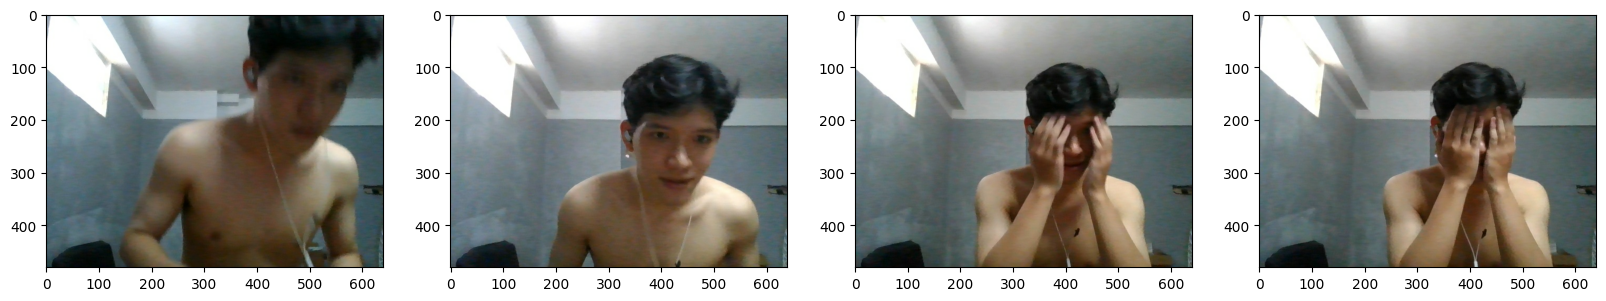

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show

# Partition Unaugmented Data

### Manually Split data into Train Test and Val

### Move the matching Labels

In [ ]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join(data_dir,folder,'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(data_dir,'labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join(data_dir,folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# Apply Image Augmentation on Images and Labels using Albumentations

### Setup Albumentations TransformPipeline

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), # 480x640 => 450x450
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

### Load a Test Image and Annotation with OpenCV and JSON

In [ ]:
img = cv2.imread(os.path.join(data_dir,'train','images','00036367-a602-11ee-a720-30d0423c1df5.jpg'))

In [ ]:
img

array([[[178, 165, 151],
        [179, 166, 152],
        [181, 165, 152],
        ...,
        [118, 107,  80],
        [119, 108,  78],
        [119, 108,  76]],

       [[178, 165, 151],
        [178, 165, 151],
        [181, 165, 152],
        ...,
        [122, 110,  86],
        [121, 109,  81],
        [119, 108,  78]],

       [[178, 165, 149],
        [178, 165, 149],
        [180, 165, 149],
        ...,
        [123, 110,  88],
        [124, 113,  86],
        [123, 112,  84]],

       ...,

       [[ 78,  66,  42],
        [ 77,  66,  39],
        [ 76,  65,  38],
        ...,
        [110, 109,  75],
        [122, 120,  86],
        [115, 113,  78]],

       [[ 78,  65,  39],
        [ 77,  65,  37],
        [ 76,  64,  36],
        ...,
        [ 97,  98,  58],
        [113, 113,  73],
        [122, 123,  81]],

       [[ 77,  65,  37],
        [ 75,  63,  35],
        [ 74,  62,  34],
        ...,
        [101, 103,  61],
        [ 99, 100,  56],
        [103, 104,  60]]

In [ ]:
with open(os.path.join(data_dir,'train','labels','00036367-a602-11ee-a720-30d0423c1df5.json'),'r') as f:
    label = json.load(f)

In [ ]:
label['shapes'][0]['points']

[[371.7391304347826, 4.347826086956587],
 [607.3913043478261, 275.6521739130435]]

In [ ]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[371.7391304347826, 4.347826086956587, 607.3913043478261, 275.6521739130435]

In [ ]:
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.5808423913043479,
 0.00905797101449289,
 0.9490489130434783,
 0.5742753623188406]

### Apply Augmentataions and View Results

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['bboxes']

[(0.4371980676328503, 0.41188405797101446, 0.9608695652173914, 1.0)]

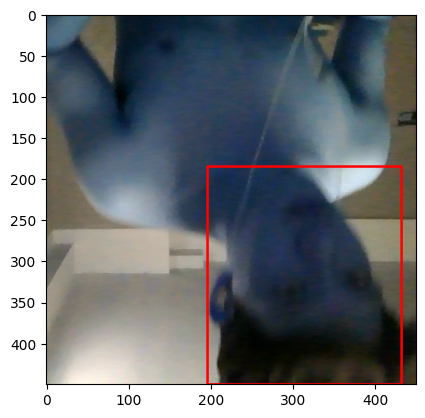

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)
plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

### Run Augmentation Pipeline

In [ ]:
# aug_data = '/content/drive/MyDrive/Deep Learning with Tensorflow/Face Detection/aug_data'

# for partition in ['train', 'test', 'val']:
#     for image in os.listdir(os.path.join(data_dir, partition, 'images')):
#         img = cv2.imread(os.path.join(data_dir, partition, 'images', image))

#         coords = [0, 0, 0.0001, 0.0001]
#         label_path = os.path.join(data_dir, partition, 'labels', f'{image.split(".")[0]}.json')
#         if os.path.exists(label_path):
#             with open(label_path, 'r') as f:
#                 label = json.load(f)

#             coords[0] = label['shapes'][0]['points'][0][0]
#             coords[1] = label['shapes'][0]['points'][0][1]
#             coords[2] = label['shapes'][0]['points'][1][0]
#             coords[3] = label['shapes'][0]['points'][1][1]
#             coords = list(np.divide(coords, [640, 480, 640, 480]))

#         try:
#             for x in range(60):
#                 augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
#                 cv2.imwrite(os.path.join(aug_data, partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

#                 annotation = {}
#                 annotation['image'] = image

#                 if os.path.exists(label_path):
#                     if len(augmented['bboxes']) == 0:
#                         annotation['bbox'] = [0,0,0,0]
#                         annotation['class'] = 0
#                     else:
#                         annotation['bbox'] = augmented['bboxes'][0]
#                         annotation['class'] = 1
#                 else:
#                     annotation['bbox'] = [0,0,0,0]
#                     annotation['class'] = 0

#                 with open(os.path.join(aug_data, partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
#                     json.dump(annotation, f)
#         except Exception as e:
#             print(e)

In [ ]:
aug_data = '/content/drive/MyDrive/Deep Learning with Tensorflow/Face Detection/aug_data'

for partition in ['train','test','val']:
    for image in os.listdir(os.path.join(data_dir, partition, 'images')):
        img = cv2.imread(os.path.join(data_dir, partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join(data_dir, partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join(aug_data, partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join(aug_data, partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

NameError: name 'os' is not defined

### Load Augmented Images to Tensorflow Dataset

In [ ]:
train_images = tf.data.Dataset.list_files(f'{aug_data}/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)


In [ ]:
test_images = tf.data.Dataset.list_files(f'{aug_data}/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files(f'{aug_data}/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

# Prepare Labels

### Build Label loading function

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

### Load Labels to Tensorflow Dataset

In [ ]:
train_labels = tf.data.Dataset.list_files(f'{aug_data}/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files(f'{aug_data}/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files(f'{aug_data}/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.6904, 0.    , 1.    , 0.546 ], dtype=float16))

# Combine Label and Image Samples

### Check Partition Lengths

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### Create Final Datasets (Images/Labels)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()

(array([[[[2.93075979e-01, 3.16176474e-01, 4.74999994e-01],
          [3.01409304e-01, 3.02267164e-01, 4.95404422e-01],
          [3.04595590e-01, 3.04595590e-01, 4.74203438e-01],
          ...,
          [4.14215684e-01, 4.18137252e-01, 5.90686262e-01],
          [4.05759811e-01, 4.06678915e-01, 5.75367630e-01],
          [3.89828444e-01, 3.95220578e-01, 5.63357830e-01]],
 
         [[3.16176474e-01, 3.24019611e-01, 4.80514705e-01],
          [3.17095578e-01, 3.21936280e-01, 4.91727948e-01],
          [2.93627441e-01, 3.09313715e-01, 4.58333343e-01],
          ...,
          [4.03431386e-01, 4.08272058e-01, 5.78063726e-01],
          [3.80943626e-01, 3.88786763e-01, 5.48590660e-01],
          [3.69240195e-01, 3.81985307e-01, 5.32475471e-01]],
 
         [[2.96875000e-01, 3.05208325e-01, 4.91973042e-01],
          [3.03799033e-01, 3.07720602e-01, 4.80269611e-01],
          [3.01899523e-01, 3.09313715e-01, 4.71384794e-01],
          ...,
          [3.89215678e-01, 3.85294110e-01, 5.4301

### View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

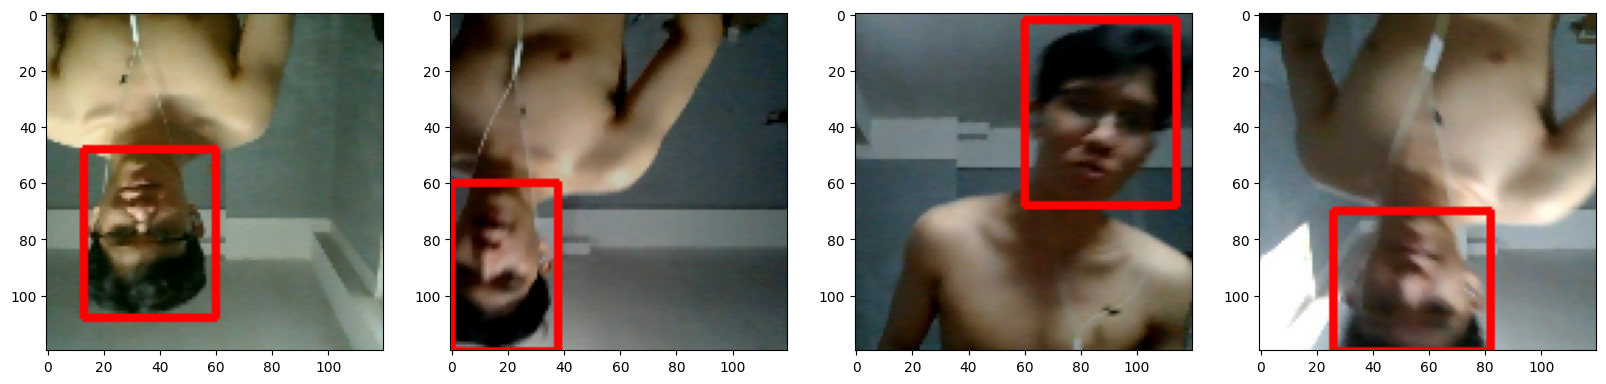

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning using the Functional API

### Import Layers and Base Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### Download VGG16

In [ ]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Build instance of Network

In [ ]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### Test out Neural Network

In [ ]:
facetracker = build_model()
facetracker.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [ ]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [ ]:
classes, coords = facetracker.predict(X)
classes, coords

1/1 [==============================] - 3s 3s/step


(array([[0.49809334],
        [0.50578433],
        [0.5226219 ],
        [0.5030915 ],
        [0.6093865 ],
        [0.4819328 ],
        [0.39625117],
        [0.515028  ]], dtype=float32),
 array([[0.37511876, 0.61776185, 0.4461031 , 0.2713483 ],
        [0.4366053 , 0.5644706 , 0.47747198, 0.24799311],
        [0.36619753, 0.53423476, 0.45599183, 0.24520637],
        [0.40535843, 0.5819364 , 0.51369447, 0.2990845 ],
        [0.43517935, 0.56562275, 0.4637233 , 0.2527255 ],
        [0.32958645, 0.62584263, 0.520199  , 0.2666486 ],
        [0.35343766, 0.64920896, 0.53801876, 0.2899627 ],
        [0.3687574 , 0.58431286, 0.3483193 , 0.282144  ]], dtype=float32))

# Define Losses and Optimizers

### Define Optimizer and LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

###  Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### Test out Loss Metrics

In [ ]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.056103>

In [ ]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6911231>

In [ ]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=8.056103>

# Train Neural Network

### Create Custom Model Class

In [ ]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

### Train

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 79s 81ms/step - total_loss: 0.4571 - class_loss: 0.0883 - regress_loss: 0.4129 - val_total_loss: 0.0279 - val_class_loss: 0.0037 - val_regress_loss: 0.0260
Epoch 2/10
473/473 [==============================] - 66s 76ms/step - total_loss: 0.0959 - class_loss: 0.0231 - regress_loss: 0.0843 - val_total_loss: 0.0106 - val_class_loss: 9.1663e-05 - val_regress_loss: 0.0105
Epoch 3/10
473/473 [==============================] - 62s 71ms/step - total_loss: 0.0587 - class_loss: 0.0108 - regress_loss: 0.0533 - val_total_loss: 0.0194 - val_class_loss: 4.6524e-05 - val_regress_loss: 0.0194
Epoch 4/10
473/473 [==============================] - 62s 77ms/step - total_loss: 0.0246 - class_loss: 0.0041 - regress_loss: 0.0225 - val_total_loss: 0.0226 - val_class_loss: 2.9328e-04 - val_regress_loss: 0.0225
Epoch 5/10
473/473 [==============================] - 59s 70ms/step - total_loss: 0.0182 - class_loss: 0.0038 - regress_loss: 0.0163 - val_total_los

### Plot Performance

In [ ]:
hist.history

{'total_loss': [0.04830009117722511,
  0.020851941779255867,
  0.018042506650090218,
  0.00820900872349739,
  0.004009580239653587,
  0.0021641512867063284,
  0.003943717107176781,
  0.003445075824856758,
  0.0033227261155843735,
  0.0009035809780471027],
 'class_loss': [0.0008642596076242626,
  0.00012330629397183657,
  3.576373273972422e-05,
  0.000565755763091147,
  6.102540282881819e-05,
  3.874304184137145e-07,
  0.0004534031031653285,
  6.437345291487873e-06,
  6.461977318394929e-05,
  2.3276634237845428e-05],
 'regress_loss': [0.04786796122789383,
  0.020790288224816322,
  0.0180246252566576,
  0.007926130667328835,
  0.00397906731814146,
  0.0021639575716108084,
  0.0037170154973864555,
  0.003441857174038887,
  0.003290416207164526,
  0.0008919426472857594],
 'val_total_loss': [0.02790217474102974,
  0.010586556978523731,
  0.019430648535490036,
  0.022626914083957672,
  0.005984270013868809,
  0.014900719746947289,
  0.021436192095279694,
  0.007194051519036293,
  0.008095131

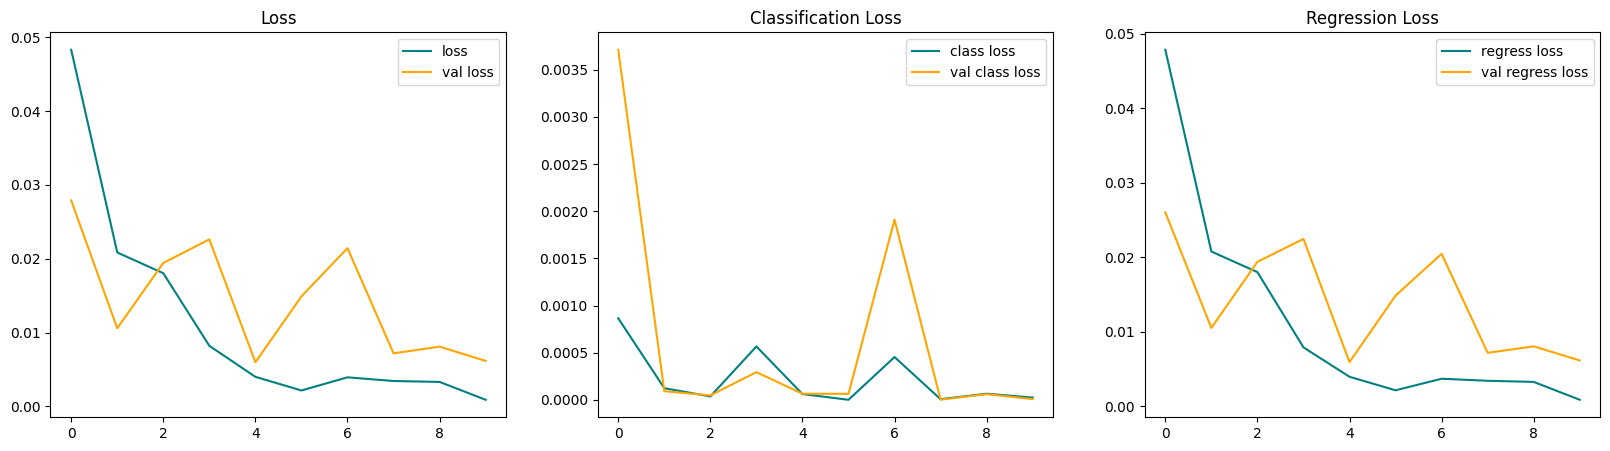

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Make Predictions

### Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 20ms/step


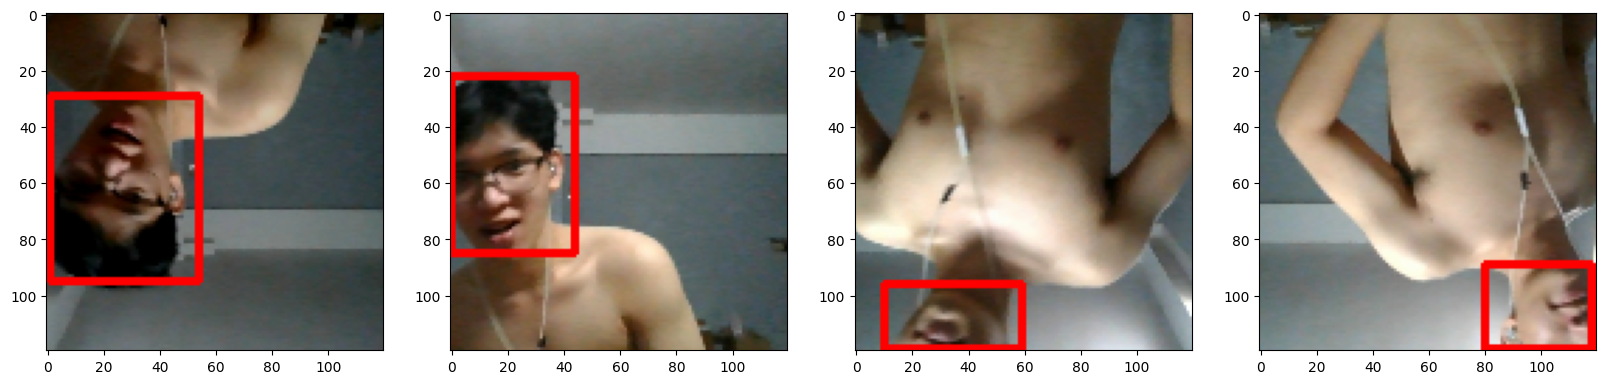

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Save the Model

In [ ]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
facetracker = load_model('facetracker.h5')

### Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()